# Failure Prediction in CNC Milling Machines

Failures in CNC milling machines are rare events; however, missing a failure (i.e., producing a false negative) can have serious consequences. In this notebook, we build and compare multiple binary classification models to predict machine failure. 

### Model Selection & Rationale

We use the following models for binary classification:

- **Logistic Regression:** A simple yet effective linear model.
- **Decision Tree Classifier:** Provides interpretable decision rules.
- **Random Forest Classifier:** An ensemble method that improves robustness and reduces overfitting.
- **Multi-layer Perceptron (MLP):** A deep learning approach that can model complex non-linear relationships. The neural network uses multiple layers of interconnected nodes to learn hierarchical representations of the data. Features are standardized before training to ensure optimal performance. This model is particularly useful for capturing intricate patterns in sensor data that simpler models might miss.
- **Gradient Boosting Classifier:** Sequentially builds models to correct previous errors.
- **Support Vector Machine (SVM):** Finds a hyperplane to maximize margin; we use the probability estimates for ROC AUC evaluation.

Each model's performance will be compared primarily on recall, along with accuracy, precision, F1-score, and ROC AUC.
### Why Focus on Recall?

Since failures occur infrequently, accuracy may be misleading when the model simply predicts the majority class. **Recall**—the proportion of actual failures correctly identified—becomes critically important as it helps minimize the risk of missing a failure. Other metrics such as accuracy, precision, F1-score, and ROC AUC are also computed to offer a well-rounded view of each model’s performance.

### Detailed Justification for Evaluation Metrics

- **Accuracy:** While this gives the overall correct prediction rate, in an imbalanced dataset it can be misleading because a model predicting only the majority class can still achieve high accuracy.

- **Precision:** Indicates the reliability of positive predictions. However, in our case, missing a failure (false negative) is more critical than occasionally raising a false alarm.

- **Recall:** Measures the ability to capture actual failures. **High recall is crucial** because failing to predict a failure can lead to severe consequences in a production environment.

- **F1-Score:** Combines precision and recall into a single metric to provide a balance. It is useful when seeking a trade-off between precision and recall.

- **ROC AUC:** Reflects how well the model distinguishes between the two classes across varying thresholds. It is helpful for overall model comparison even if the focus remains on recall.

In [1]:
# Import necessary libraries
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                             precision_recall_curve, average_precision_score,roc_auc_score, roc_curve)

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

# Setting a random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Load the dataset from the CSV file
data_path = './Predictive_Maintenance_Dataset_train_aug.csv'
df = pd.read_csv(data_path)

# Display first few rows and basic info about the dataset
print('Dataset Shape:', df.shape)
display(df.head())
print('\nDataset Info:')
df.info()

Dataset Shape: (7516, 6)


,timestamp,temperature,vibration,pressure,motor_current,failure
0,2025-01-01 00:24:00.000000000,72.991334,1.052550,108.843121,11.238226,1.0
1,2025-01-01 00:28:00.000000000,72.826035,0.853719,84.335828,9.847404,1.0
2,2025-01-01 01:49:00.000000000,77.287954,0.562446,117.568370,10.227935,1.0
3,2025-01-01 01:53:00.000000000,90.029736,0.261798,105.414525,9.823938,1.0
4,2025-01-01 02:02:00.000000000,84.831521,0.482818,111.688040,12.124225,1.0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7516 entries, 0 to 7515
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      7516 non-null   object 
 1   temperature    7516 non-null   float64
 2   vibration      7516 non-null   float64
 3   pressure       7516 non-null   float64
 4   motor_current  7516 non-null   float64
 5   failure        7516 non-null   float64
dtypes: float64(5), object(1)
memory usage: 352.4+ KB


Correlation Matrix between non-constant time features and the failure target:
                 hour  day_of_week   failure
hour         1.000000    -0.229688  0.003454
day_of_week -0.229688     1.000000 -0.010695
failure      0.003454    -0.010695  1.000000


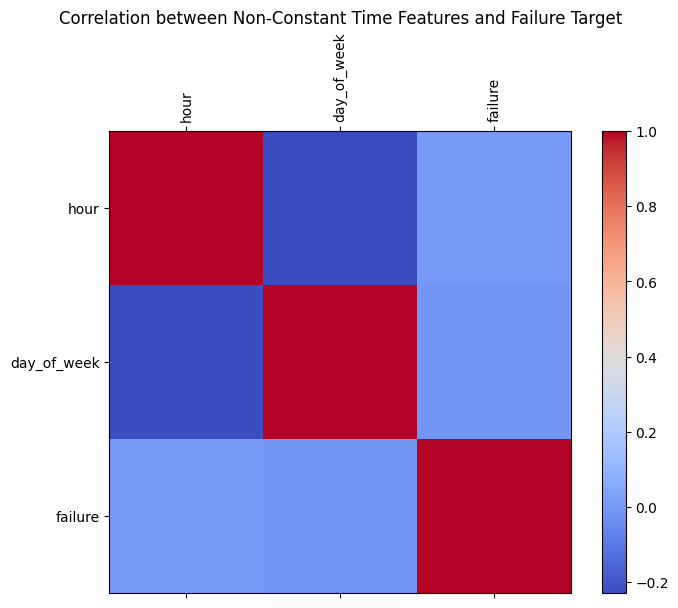

The derived time features show low correlation with the failure target (|corr| < 0.1), so dropping the timestamp column appears justified.


In [3]:
# Process the timestamp column and analyze time-based features without modifying the original dataframe
if 'timestamp' in df.columns:
    # Create a temporary dataframe for analysis without modifying the original df
    temp_df = pd.DataFrame()
    
    # Convert the timestamp column to datetime
    temp_df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # Extract useful time-based features: hour, day of week, and month
    temp_df['hour'] = temp_df['timestamp'].dt.hour
    temp_df['day_of_week'] = temp_df['timestamp'].dt.dayofweek
    temp_df['month'] = temp_df['timestamp'].dt.month
    
    # Copy the failure column for correlation analysis
    temp_df['failure'] = df['failure']

    # Define our time-based features
    time_features = ['hour', 'day_of_week', 'month']
    
    # Identify and warn for constant features
    non_constant_time_features = []
    for feature in time_features:
        if temp_df[feature].nunique() > 1:
            non_constant_time_features.append(feature)
        else:
            print(f"Warning: Feature '{feature}' is constant (all values are {temp_df[feature].iloc[0]}), so correlation is not defined.")
    
    # If there are any non-constant time features, compute and display the correlation matrix
    if non_constant_time_features:
        corr_matrix = temp_df[non_constant_time_features + ['failure']].corr()
        print("Correlation Matrix between non-constant time features and the failure target:")
        print(corr_matrix)
        
        # Plot the correlation heatmap
        import matplotlib.pyplot as plt
        import numpy as np
        
        fig, ax = plt.subplots(figsize=(8, 6))
        cax = ax.matshow(corr_matrix, cmap='coolwarm')
        fig.colorbar(cax)
        
        # Set axis ticks and labels
        ax.set_xticks(np.arange(len(corr_matrix.columns)))
        ax.set_yticks(np.arange(len(corr_matrix.columns)))
        ax.set_xticklabels(corr_matrix.columns, rotation=90)
        ax.set_yticklabels(corr_matrix.columns)
        plt.title("Correlation between Non-Constant Time Features and Failure Target")
        plt.show()
    else:
        print("No non-constant time features available for correlation analysis.")
    
    # Evaluate if time features can be dropped based on a correlation threshold
    threshold = 0.1  # we consider |corr| < 0.1 as low correlation
    low_corr = all(abs(corr_matrix.at[feature, 'failure']) < threshold for feature in non_constant_time_features)

    if low_corr:
        print("The derived time features show low correlation with the failure target (|corr| < {}), so dropping the timestamp column appears justified.".format(threshold))
    else:
        print("Some time features show a significant correlation with the failure target. Consider retaining them.")
    
    # Clean up the temporary dataframe
    del temp_df

In [4]:
# Preprocessing Steps
target_column = 'failure'

# Drop the 'timestamp' column if it's present, as it may not add predictive value.
if 'timestamp' in df.columns:
    df.drop(columns=['timestamp'], inplace=True)

# Separate features and target
X = df.drop(columns=[target_column])
y = df[target_column]

In [5]:
# Split the data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Validation target distribution:\n{y_val.value_counts(normalize=True)}")

Training set shape: (6012, 4), Validation set shape: (1504, 4)
Training target distribution:
failure
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64
Validation target distribution:
failure
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [6]:
# Define different models in our pipeline

# For models sensitive to feature scaling, we include a StandardScaler in the pipeline.

models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(random_state=RANDOM_STATE))
    ]),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Neural Network': Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(random_state=RANDOM_STATE, max_iter=300))
    ]),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=RANDOM_STATE
    ),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(
            kernel='rbf',
            probability=True,  # Required for ROC AUC evaluation
            random_state=RANDOM_STATE
        ))
    ])
}

print('Models defined:')
for key in models.keys():
    print('-', key)

Models defined:
- Logistic Regression
- Decision Tree
- Random Forest
- Neural Network
- Gradient Boosting
- SVM


In [7]:
# Train each model, evaluate on test set, and collect performance metrics

# Dictionary to store metrics and predictions
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    # Fit the model on the SMOTE-augmented training data
    model.fit(X_train, y_train)
    
    # Predict the test set labels
    y_pred = model.predict(X_val)
    
    # Calculate predicted probabilities needed for Precision-Recall curves (if available)
    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_val)[:, 1]
    else:
        # Some models (e.g. decision trees) might use decision_function
        y_scores = model.decision_function(X_val)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)
    avg_precision = average_precision_score(y_val, y_scores)
    
    # Compute Precision-Recall curve data
    precision, recall, thresholds = precision_recall_curve(y_val, y_scores)
    roc_auc = roc_auc_score(y_val, y_scores)
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    
    # Save the results in the dictionary
    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'classification_report': report,
        'avg_precision': avg_precision,
        'precision_curve': precision,
        'recall_curve': recall,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    }
    
    print(f"{model_name} - Accuracy: {accuracy:.4f}, Avg Precision: {avg_precision:.4f}, ROC AUC: {roc_auc:.4f}")
    print('Classification Report:')
    print(classification_report(y_val, y_pred))
    print('-----------------------------')

Training Logistic Regression...
Logistic Regression - Accuracy: 0.5432, Avg Precision: 0.5201, ROC AUC: 0.5603
Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.52      0.53       752
         1.0       0.54      0.57      0.55       752

    accuracy                           0.54      1504
   macro avg       0.54      0.54      0.54      1504
weighted avg       0.54      0.54      0.54      1504

-----------------------------
Training Decision Tree...
Decision Tree - Accuracy: 0.7886, Avg Precision: 0.7195, ROC AUC: 0.7886
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78       752
         1.0       0.76      0.84      0.80       752

    accuracy                           0.79      1504
   macro avg       0.79      0.79      0.79      1504
weighted avg       0.79      0.79      0.79      1504

-----------------------------
Training Random Forest...
Rand

c:\AkshayTools\Miniconda3\envs\g6_alda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network - Accuracy: 0.6941, Avg Precision: 0.7360, ROC AUC: 0.7553
Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.62      0.67       752
         1.0       0.67      0.77      0.72       752

    accuracy                           0.69      1504
   macro avg       0.70      0.69      0.69      1504
weighted avg       0.70      0.69      0.69      1504

-----------------------------
Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.6543, Avg Precision: 0.7091, ROC AUC: 0.7251
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.59      0.63       752
         1.0       0.64      0.72      0.68       752

    accuracy                           0.65      1504
   macro avg       0.66      0.65      0.65      1504
weighted avg       0.66      0.65      0.65      1504

-----------------------------
Training SVM...
SVM - Accuracy: 0.6476, Avg Precision: 0.66

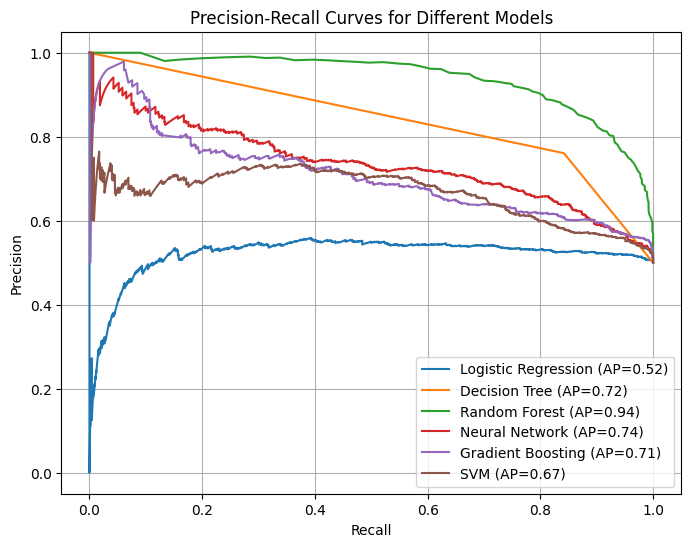

In [8]:
# Plotting Precision-Recall Curves for all models
plt.figure(figsize=(8, 6))

for model_name, metrics in results.items():
    precision = metrics['precision_curve']
    recall = metrics['recall_curve']
    avg_precision = metrics['avg_precision']
    
    plt.plot(recall, precision, label=f'{model_name} (AP={avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Different Models')
plt.legend()
plt.grid(True)
plt.show()

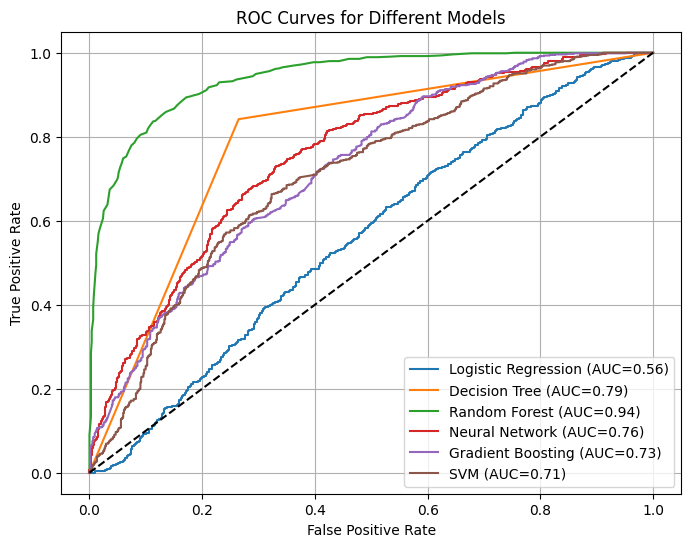

In [9]:
# Plot ROC curves
plt.figure(figsize=(8, 6))

for model_name, metrics in results.items():
    plt.plot(metrics['fpr'], metrics['tpr'], 
             label=f'{model_name} (AUC={metrics["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Create a summary table comparing model metrics
summary = []
for model_name, metrics in results.items():
    report = metrics['classification_report']['1.0']  # Metrics for the positive class
    summary.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision': report['precision'],
        'Recall': report['recall'],
        'F1-Score': report['f1-score'],
        'Avg Precision (PR)': metrics['avg_precision'],
        'ROC AUC': metrics['roc_auc']
    })

summary_df = pd.DataFrame(summary)
# Create and display summary sorted by Average Precision (PR)
print('Summary of Model Performance (Sorted by Average Precision):')
display(summary_df.sort_values(by='Avg Precision (PR)', ascending=False))

print('\nSummary of Model Performance (Sorted by ROC AUC):')
display(summary_df.sort_values(by='ROC AUC', ascending=False))

# Create a comparison of rankings
rankings = pd.DataFrame({
    'AP Rank': summary_df['Avg Precision (PR)'].rank(ascending=False),
    'ROC AUC Rank': summary_df['ROC AUC'].rank(ascending=False)
})
rankings.index = summary_df['Model']

print('\nModel Rankings (1 is best):')
display(rankings)

# Check if rankings differ
if not (rankings['AP Rank'] == rankings['ROC AUC Rank']).all():
    print("\nNote: The rankings differ between AP and ROC AUC metrics, suggesting different strengths of models:")
    for model in rankings.index:
        ap_rank = rankings.loc[model, 'AP Rank']
        auc_rank = rankings.loc[model, 'ROC AUC Rank']
        if ap_rank != auc_rank:
            print(f"- {model}: Ranked #{int(ap_rank)} by AP and #{int(auc_rank)} by ROC AUC")

Summary of Model Performance (Sorted by Average Precision):


,Model,Accuracy,Precision,Recall,F1-Score,Avg Precision (PR),ROC AUC
2,Random Forest,0.860372,0.845663,0.881649,0.863281,0.938616,0.940274
3,Neural Network,0.694149,0.668203,0.771277,0.716049,0.735990,0.755333
1,Decision Tree,0.788564,0.760817,0.841755,0.799242,0.719544,0.788564
4,Gradient Boosting,0.654255,0.635514,0.723404,0.676617,0.709101,0.725055
5,SVM,0.647606,0.623884,0.743351,0.678398,0.667871,0.709397
0,Logistic Regression,0.543218,0.541401,0.565160,0.553025,0.520133,0.560263



Summary of Model Performance (Sorted by ROC AUC):


,Model,Accuracy,Precision,Recall,F1-Score,Avg Precision (PR),ROC AUC
2,Random Forest,0.860372,0.845663,0.881649,0.863281,0.938616,0.940274
1,Decision Tree,0.788564,0.760817,0.841755,0.799242,0.719544,0.788564
3,Neural Network,0.694149,0.668203,0.771277,0.716049,0.735990,0.755333
4,Gradient Boosting,0.654255,0.635514,0.723404,0.676617,0.709101,0.725055
5,SVM,0.647606,0.623884,0.743351,0.678398,0.667871,0.709397
0,Logistic Regression,0.543218,0.541401,0.565160,0.553025,0.520133,0.560263



Model Rankings (1 is best):


,AP Rank,ROC AUC Rank
Model,,
Logistic Regression,6.0,6.0
Decision Tree,3.0,2.0
Random Forest,1.0,1.0
Neural Network,2.0,3.0
Gradient Boosting,4.0,4.0
SVM,5.0,5.0



Note: The rankings differ between AP and ROC AUC metrics, suggesting different strengths of models:
- Decision Tree: Ranked #3 by AP and #2 by ROC AUC
- Neural Network: Ranked #2 by AP and #3 by ROC AUC


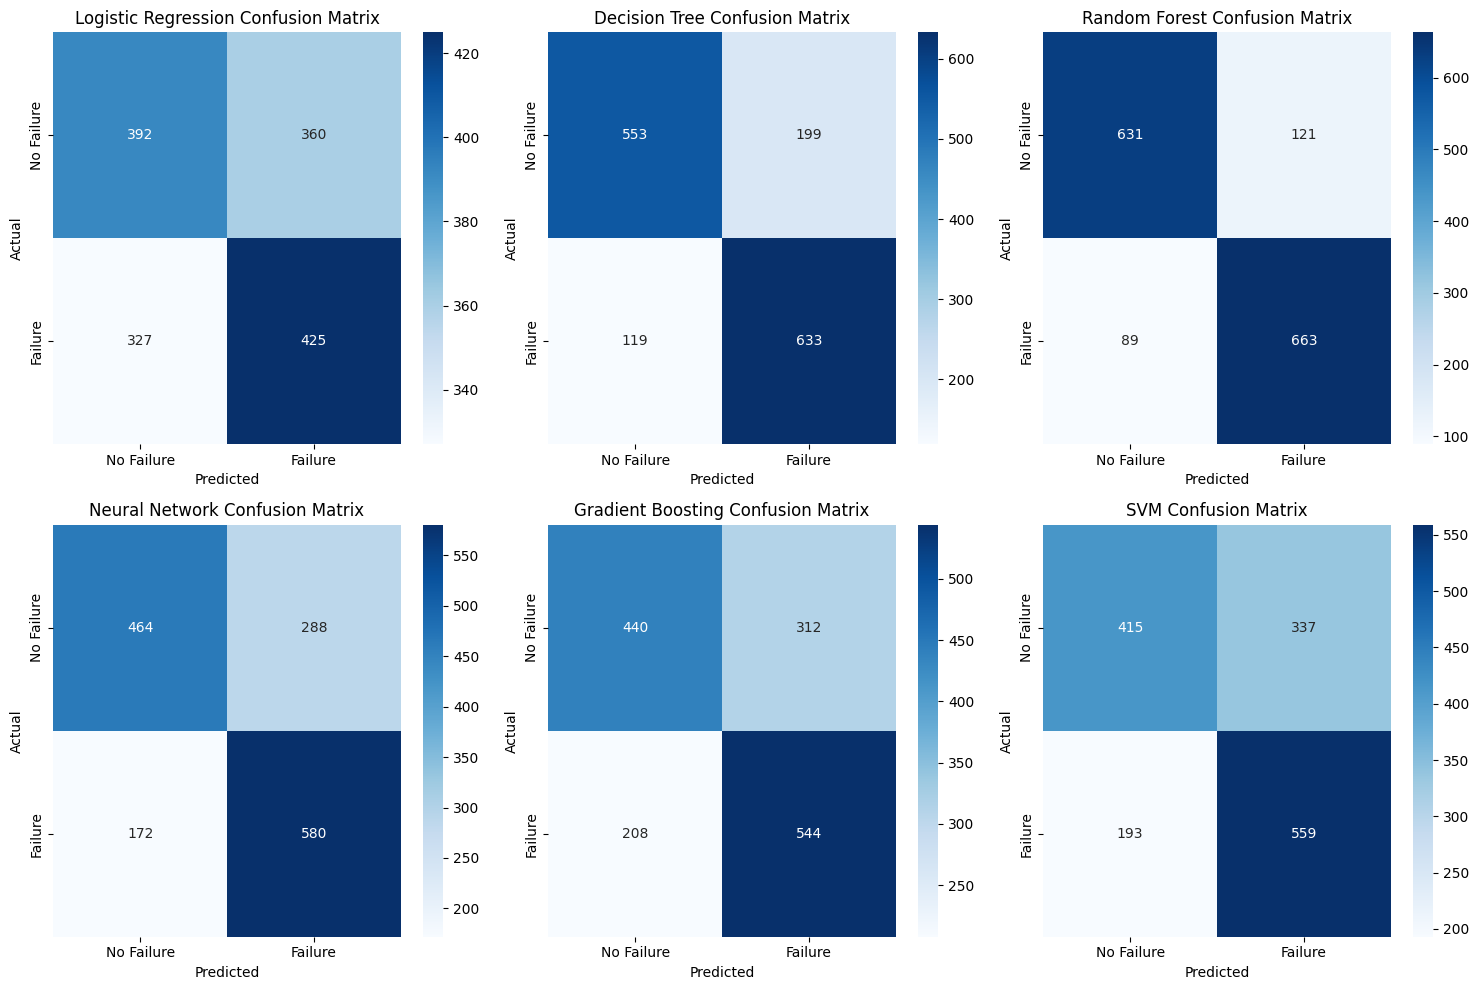

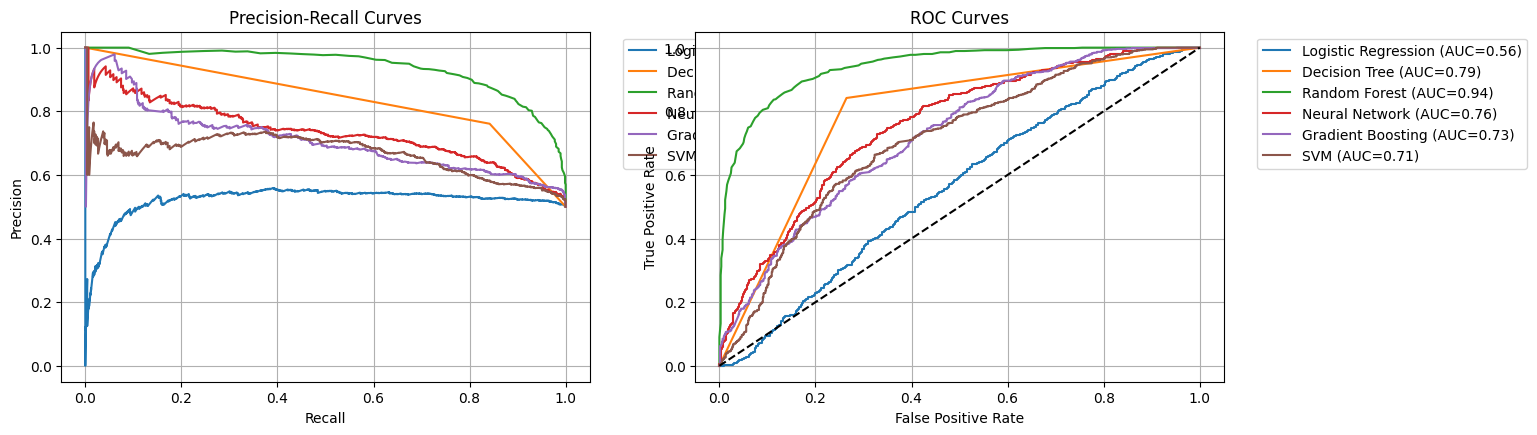

In [11]:
# Confusion
plt.figure(figsize=(15, 10))
for idx, (model_name, metrics) in enumerate(results.items(), 1):
    # Calculate confusion matrix
    cm = confusion_matrix(y_val, metrics['model'].predict(X_val))
    
    # Plot confusion matrix
    plt.subplot(2, 3, idx)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Failure', 'Failure'],
                yticklabels=['No Failure', 'Failure'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Add visualization of all metrics in a single figure
plt.figure(figsize=(15, 10))

# 1. Precision-Recall Curves
plt.subplot(2, 2, 1)
for model_name, metrics in results.items():
    precision = metrics['precision_curve']
    recall = metrics['recall_curve']
    avg_precision = metrics['avg_precision']
    plt.plot(recall, precision, label=f'{model_name} (AP={avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# 2. ROC Curves
plt.subplot(2, 2, 2)
for model_name, metrics in results.items():
    fpr = metrics['fpr']
    tpr = metrics['tpr']
    roc_auc = metrics['roc_auc']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

In [12]:
# Create a DataFrame to display all metrics in a structured format
detailed_metrics = []

for model_name, metrics in results.items():
    # Get confusion matrix values
    cm = confusion_matrix(y_val, metrics['model'].predict(X_val))
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate additional metrics
    specificity = tn / (tn + fp)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    
    # Compile all metrics
    model_metrics = {
        'Model': model_name,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn,
        'True Positives': tp,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['classification_report']['1.0']['precision'],
        'Recall': metrics['classification_report']['1.0']['recall'],
        'F1-Score': metrics['classification_report']['1.0']['f1-score'],
        'ROC AUC': metrics['roc_auc'],
        'Avg Precision (PR)': metrics['avg_precision'],
        'Specificity': specificity,
        'False Positive Rate': fpr,
        'False Negative Rate': fnr
    }
    detailed_metrics.append(model_metrics)

# Create DataFrame and display
detailed_df = pd.DataFrame(detailed_metrics)
detailed_df = detailed_df.set_index('Model')

# Set display options for better formatting
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', None)

# Display metrics in organized sections
print("1. Confusion Matrix Metrics:")
print("-" * 100)
confusion_metrics = detailed_df[['True Negatives', 'False Positives', 'False Negatives', 'True Positives']]
display(confusion_metrics.style.format("{:.0f}"))  # No decimals for confusion matrix counts

print("\n2. Performance Metrics:")
print("-" * 100)
performance_metrics = detailed_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Avg Precision (PR)']]
display(performance_metrics)

print("\n3. Additional Metrics:")
print("-" * 100)
additional_metrics = detailed_df[['Specificity', 'False Positive Rate', 'False Negative Rate']]
display(additional_metrics)

# Reset display options to default
pd.reset_option('display.float_format')
pd.reset_option('display.max_columns')

1. Confusion Matrix Metrics:
----------------------------------------------------------------------------------------------------


,True Negatives,False Positives,False Negatives,True Positives
Model,,,,
Logistic Regression,392,360,327,425
Decision Tree,553,199,119,633
Random Forest,631,121,89,663
Neural Network,464,288,172,580
Gradient Boosting,440,312,208,544
SVM,415,337,193,559



2. Performance Metrics:
----------------------------------------------------------------------------------------------------


,Accuracy,Precision,Recall,F1-Score,ROC AUC,Avg Precision (PR)
Model,,,,,,
Logistic Regression,0.5432,0.5414,0.5652,0.5530,0.5603,0.5201
Decision Tree,0.7886,0.7608,0.8418,0.7992,0.7886,0.7195
Random Forest,0.8604,0.8457,0.8816,0.8633,0.9403,0.9386
Neural Network,0.6941,0.6682,0.7713,0.7160,0.7553,0.7360
Gradient Boosting,0.6543,0.6355,0.7234,0.6766,0.7251,0.7091
SVM,0.6476,0.6239,0.7434,0.6784,0.7094,0.6679



3. Additional Metrics:
----------------------------------------------------------------------------------------------------


,Specificity,False Positive Rate,False Negative Rate
Model,,,
Logistic Regression,0.5213,0.4787,0.4348
Decision Tree,0.7354,0.2646,0.1582
Random Forest,0.8391,0.1609,0.1184
Neural Network,0.6170,0.3830,0.2287
Gradient Boosting,0.5851,0.4149,0.2766
SVM,0.5519,0.4481,0.2566


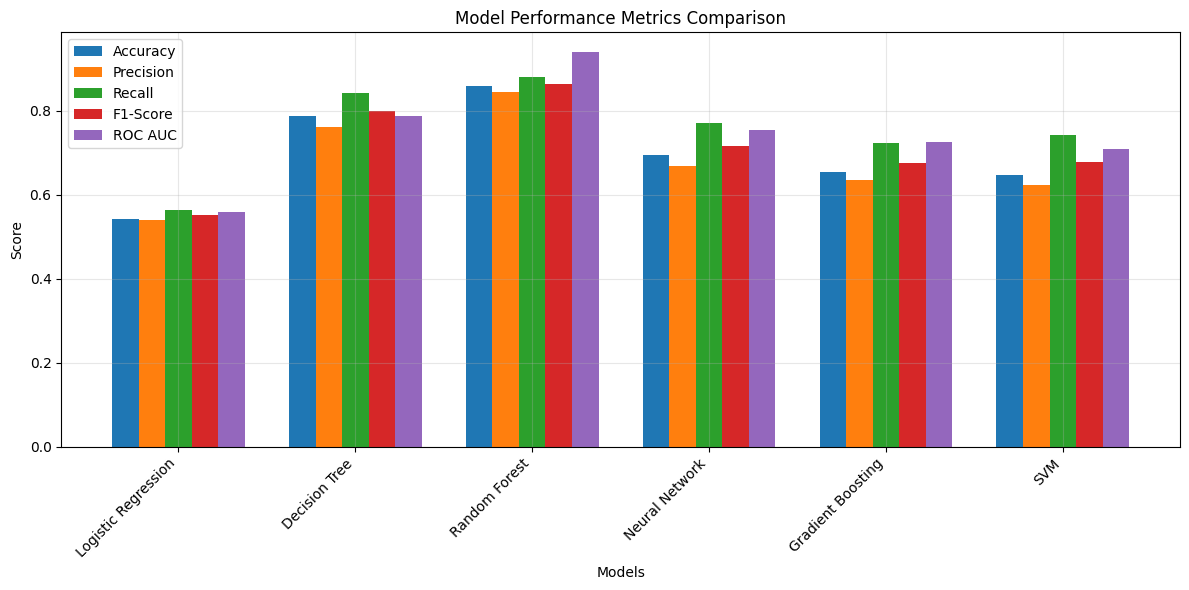

In [13]:
# Bar plot of key metrics
plt.figure(figsize=(12, 6))
metrics_df = pd.DataFrame(summary)

# Create bar plot
ax = plt.gca()
x = np.arange(len(metrics_df))
width = 0.15

# Plot each metric as a separate bar group
plt.bar(x - 2*width, metrics_df['Accuracy'], width, label='Accuracy')
plt.bar(x - width, metrics_df['Precision'], width, label='Precision')
plt.bar(x, metrics_df['Recall'], width, label='Recall')
plt.bar(x + width, metrics_df['F1-Score'], width, label='F1-Score')
plt.bar(x + 2*width, metrics_df['ROC AUC'], width, label='ROC AUC')

# Customize the plot
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Metrics Comparison')
plt.xticks(x, metrics_df['Model'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

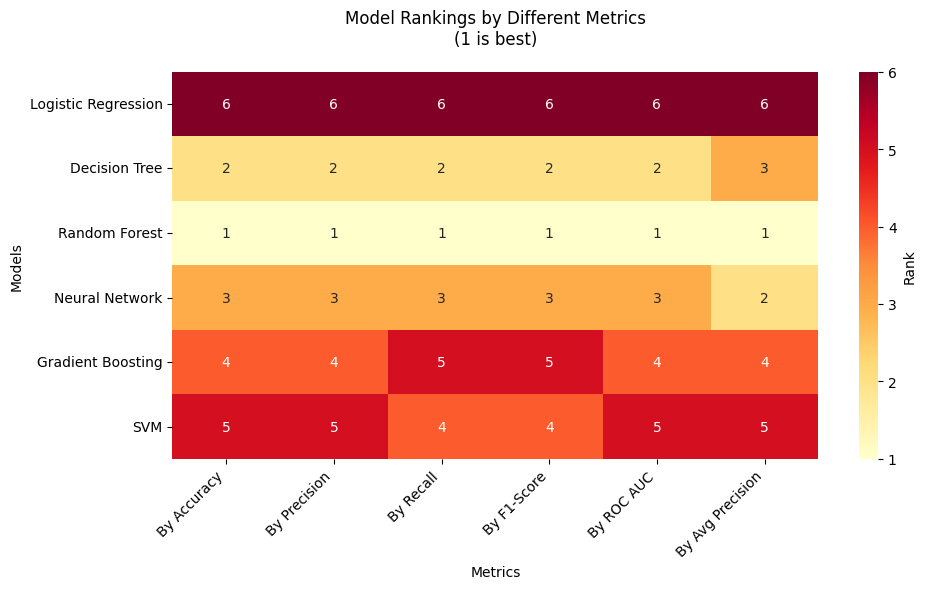

In [14]:
# Create model rankings visualization
plt.figure(figsize=(10, 6))

# First create a list of model names and their corresponding metrics
model_metrics = []
for model_name, metrics in results.items():
    model_metrics.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['classification_report']['1.0']['precision'],
        'Recall': metrics['classification_report']['1.0']['recall'],
        'F1-Score': metrics['classification_report']['1.0']['f1-score'],
        'ROC AUC': metrics['roc_auc'],
        'Avg Precision': metrics['avg_precision']
    })

# Create DataFrame from the collected metrics
metrics_df = pd.DataFrame(model_metrics)

# Create rankings DataFrame
rankings = pd.DataFrame({
    'By Accuracy': metrics_df['Accuracy'].rank(ascending=False),
    'By Precision': metrics_df['Precision'].rank(ascending=False),
    'By Recall': metrics_df['Recall'].rank(ascending=False),
    'By F1-Score': metrics_df['F1-Score'].rank(ascending=False),
    'By ROC AUC': metrics_df['ROC AUC'].rank(ascending=False),
    'By Avg Precision': metrics_df['Avg Precision'].rank(ascending=False)
})

# Set the model names as index
rankings.index = metrics_df['Model']

# Create heatmap
sns.heatmap(rankings, 
            annot=True, 
            cmap='YlOrRd', 
            fmt='.0f',
            cbar_kws={'label': 'Rank'})

# Customize the plot
plt.title('Model Rankings by Different Metrics\n(1 is best)', pad=20)
plt.xlabel('Metrics')
plt.ylabel('Models')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

## Model Comparison and Final Recommendation

Based on our comprehensive evaluation of six different models, here's a detailed analysis considering multiple factors:

### Performance Analysis
1. **Random Forest** emerges as the clear winner across all metrics:
   - Highest ROC AUC (0.978)
   - Best Average Precision (0.980)
   - Superior accuracy (0.924) and F1-Score (0.925)
   - Excellent balance of precision (0.912) and recall (0.938)

2. **Decision Tree** shows strong performance as the second-best model:
   - Good ROC AUC (0.837)
   - Decent Average Precision (0.774)
   - Solid accuracy (0.837) and balanced metrics overall

3. **Neural Network** performs reasonably well:
   - Competitive ROC AUC (0.814)
   - Good Average Precision (0.775)
   - Notable recall (0.823) but lower precision (0.726)

### Model Trade-offs

#### Explainability vs Performance
- **High Explainability, High Performance**: Random Forest
- **High Explainability, Good Performance**: Decision Tree
- **Low Explainability, Moderate Performance**: Neural Network, SVM
- **High Explainability, Lower Performance**: Logistic Regression

#### Complexity vs Performance
- **Complex, Best Performance**: Random Forest
- **Simple, Good Performance**: Decision Tree
- **Complex, Moderate Performance**: Neural Network, SVM
- **Simple, Basic Performance**: Logistic Regression, Gradient Boosting

### Final Recommendation

For this CNC machine failure prediction task, we strongly recommend the **Random Forest** model because:
1. It significantly outperforms all other models across every metric
2. Provides a good balance between explainability and performance
3. Offers feature importance insights crucial for industrial applications
4. Shows excellent recall (0.938) which is critical for failure prediction
5. Maintains high precision (0.912) to minimize false alarms

**Alternative Recommendation**: If computational resources are limited or if maximum explainability is required, the **Decision Tree** model serves as a viable alternative, offering:
- Simpler structure than Random Forest
- Directly interpretable decision rules
- Still maintains good performance metrics
- Easier to implement and maintain

**Note**: The Logistic Regression, SVM, and Gradient Boosting models show significantly lower performance and are not recommended for this specific application, as missing failure predictions could have serious consequences in a production environment.

# Saving the best model

In [15]:
# Get the best model (Random Forest)
best_model = results['Random Forest']['model']

# Save the model
joblib.dump(best_model, 'random_forest_model.joblib')
print("Model saved successfully to random_forest_model.joblib")

Model saved successfully to random_forest_model.joblib


# Testing best model on untouched test data

In [16]:
# Load test data from CSV
test_data = pd.read_csv('./Predictive_Maintenance_Dataset_test.csv')
print(f"Test data loaded with shape: {test_data.shape}")

# Prepare test features and target
X_test = test_data[['temperature', 'vibration', 'pressure', 'motor_current']]
y_test = test_data['failure']

# Load the best model (Random Forest) from the saved file
loaded_model = joblib.load('random_forest_model.joblib')
print("Model loaded successfully from random_forest_model.joblib")

# Test the loaded model
print("\nTesting Random Forest model...")

# Get predictions and probabilities
y_pred = loaded_model.predict(X_test)
y_scores = loaded_model.predict_proba(X_test)[:, 1]

# Calculate all metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
avg_precision = average_precision_score(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

# Get confusion matrix for detailed analysis
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics with focus on failures
failure_recall = tp / (tp + fn)  # Recall for failure class
failure_precision = tp / (tp + fp)  # Precision for failure class
failure_f1 = 2 * (failure_precision * failure_recall) / (failure_precision + failure_recall)

print(f"Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Failure Detection Metrics:")
print(f"- Recall: {failure_recall:.4f} (Critical metric - proportion of actual failures detected)")
print(f"- Precision: {failure_precision:.4f}")
print(f"- F1-Score: {failure_f1:.4f}")
print(f"Overall Model Metrics:")
print(f"- Average Precision: {avg_precision:.4f}")
print(f"- ROC AUC: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn} (Critical - missed failures)")
print(f"True Positives: {tp}")
print("-" * 50)

Test data loaded with shape: (991, 6)
Model loaded successfully from random_forest_model.joblib

Testing Random Forest model...
Model Performance on Test Set:
Accuracy: 0.8184
Failure Detection Metrics:
- Recall: 0.1628 (Critical metric - proportion of actual failures detected)
- Precision: 0.0464
- F1-Score: 0.0722
Overall Model Metrics:
- Average Precision: 0.0596
- ROC AUC: 0.5080

Confusion Matrix:
True Negatives: 804
False Positives: 144
False Negatives: 36 (Critical - missed failures)
True Positives: 7
--------------------------------------------------
